<a href="https://colab.research.google.com/github/Max-FM/IAA-Social-Distancing/blob/master/FFT_Satellite_Roads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Satellite Traffic Analysis

###Install required packages

In [ ]:
!pip install rasterio
!pip install xarray
!pip install rioxarray
!pip install scikit-image

     |████████████████████████████████| 18.2MB 1.3MB/s 
     |████████████████████████████████| 993kB 2.5MB/s 
     |████████████████████████████████| 10.9MB 194kB/s 
  Created wheel for rioxarray: filename=rioxarray-0.0.31-cp36-none-any.whl size=39288 sha256=ae0504ff1beeb0a7a83c5257bedec3d043c01c633fb2d867e32c3fc5403ead42
  Stored in directory: /root/.cache/pip/wheels/f8/fc/81/dd1a9a3a76e245ca2b0f7c7f42069b4b1df03680dee0f4eba9
Successfully built rioxarray


###Import Packages

In [ ]:
%matplotlib inline

import rasterio as rio

import xarray as xr
import rioxarray as riox

import numpy as np

from skimage.io import imread
from skimage.color import rgb2grey

import matplotlib.pyplot as plt

from datetime import datetime as dt

from glob import glob

###Mount Google Drive

**Disclaimer:** Satellite images are not publicly available in the GitHub repository in order to avoid potential legal issues. The images used are available internally to other researchers at the University of Portsmouth [here](https://drive.google.com/drive/folders/1xQC_aN16BqfVdy6XJPPkF65CELGztbS8?usp=sharing). Access is restricted to external persons and all external access requests will be denied. Should the user wish to acquire the images themselves, the corresponding shapefiles are publicly available in the repository. I suggest uploading the images to Google Drive and mounting using the cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Edit as required.
path_to_directory = '/content/drive/My Drive/Social Distancing Project/Fourier Analysis/Roads/Images/ExpositionBlvd_LA_May-Jun2020_PSScene4Band_Explorer'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


###Load in GeoTIFF

In [ ]:
def datetime_parser(tiff_path):
    tiff_datetime_str = ''.join(tiff_path.split('/')[-1].split('_')[0:2])
    return dt.strptime(tiff_datetime_str, '%Y%m%d%H%M%S')

def datetime_str(tiffPath):
    return dt.strftime(datetime_parser(tiffPath), '%d/%m/%Y (%H:%M:%S)')

def print_aquisition_date(tiff_path):
    print('Aquisition Date (Time): ' + datetime_str(tiff_path))

tiffPaths = glob(f'{path_to_directory}/files/*SR_clip.tif')
tiffPath = tiffPaths[0] # Feel free to edit

# Open and reproject to WGS84 coordinate system.
raster = riox.open_rasterio(tiffPath)
raster = raster.rio.reproject('EPSG:4326')
# Split into bands and trim null pixels.
raster_b, raster_g, raster_r, raster_nir = raster[:,3:-3,:]

display(raster)
print_aquisition_date(tiffPath)

<xarray.DataArray (band: 4, y: 18, x: 264)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * x            (x) float64 -118.3 -118.3 -118.3 ... -118.3 -118.3 -118.3
  * y            (y) float64 34.02 34.02 34.02 34.02 ... 34.02 34.02 34.02 34.02
  * band         (band) int64 1 2 3 4
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    _FillValue:    0.0

Aquisition Date (Time): 17/05/2020 (18:16:47)


###Plot the images

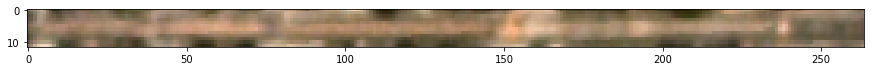

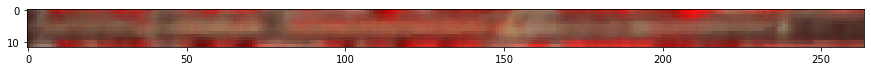

In [ ]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

# Create RBG image and NIR-RG composite images.
raster_rgb = make_composite(raster_r, raster_g, raster_b)
raster_nrg = make_composite(raster_nir, raster_r, raster_g)

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(raster_rgb);
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(raster_nrg); #Highlights vegetation.

###Perform Fast Fourier Transforms

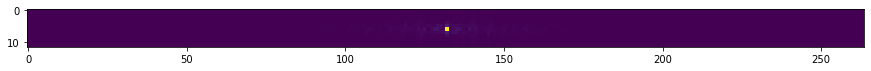

In [ ]:
from scipy.fft import fft2, fftshift, ifft2
from skimage.color import rgb2grey

#Convert to greyscale and transform.
raster_grey = rgb2grey(raster_rgb)
ft = fftshift(fft2(raster_grey))

plt.figure(figsize=(15,30))
plt.imshow(abs(ft));

###Mask FFT and Plot

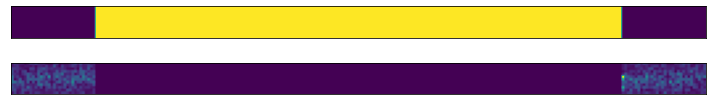

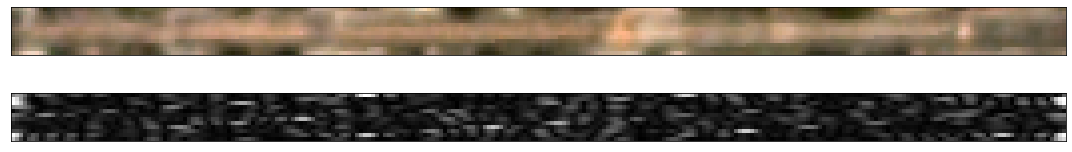

In [ ]:
#Create pixel grid.
x, y = np.arange(0, raster_g.shape[1]), np.arange(0, raster_g.shape[0])
x, y = x - np.median(x), y - np.median(y)
X, Y = np.meshgrid(x,y)

#Define pixel mask
R = 100
mask = X**2 + Y**2 < R**2

#Mask FFT and transform back into image space.
maskedFT = np.ma.array(ft, mask=mask)
maskedRaster = ifft2(maskedFT.filled(0))

# Plot pixel mask and masked FFT.
fig, ax = plt.subplots(nrows=2, figsize=(10,2))
ax[0].imshow(mask);
ax[1].imshow(abs(maskedFT.filled(0)));
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()

#Plot image before and after masked FFT. 
fig, ax = plt.subplots(figsize=(15,3), nrows=2)
ax[0].imshow(raster_rgb);
ax[1].imshow(abs(maskedRaster), cmap='Greys_r');
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()

plt.savefig('/content/fftRealRoads.jpg', dpi=200, bbox_inches='tight')